### Interpreting Machine Learning Models with Counterfactuals

This notebook accompanies the Practical Cheminformatics blog post "[Using Counterfactuals to Understand Machine Learning Models"](https://practicalcheminformatics.blogspot.com/2023/05/using-counterfactuals-to-understand.html). 

To run this notebook you need to first download and gunzip the file replacements02_sc2.5.db.gz from [http://www.qsar4u.com/pages/crem.php](http://www.qsar4u.com/pages/crem.php)

In this notebook we'll build a machine learning model then use counterfactuals to interpret the results of the model. We'll perform the following steps. 
1. Build a classification model to predict aqeous solubility
2. Generate analogs of our target molecule with CrEM
3. Calculate similarity and solubility for the analogs


### Installation
<pre>
pip install rdkit PyTDC useful_rdkit_utils tqdm scikit-learn numpy seaborn exmol pandas mols2grid crem
</pre>

Lots of imports

In [1]:
from rdkit import Chem, DataStructs
from tdc.single_pred import ADME
import useful_rdkit_utils as uru
from tqdm.auto import tqdm
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, matthews_corrcoef
import exmol
import pandas as pd
import mols2grid
from crem.crem import mutate_mol
import requests
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage

Make the structure images prettier. 

In [2]:
Chem.rdDepictor.SetPreferCoordGen(True) 

### 1. Build a classification model to predict aqeous solubility

Enable Pandas progress_apply

In [3]:
tqdm.pandas()

Get solubility data from the [Therapeutic Data Commons](https://tdcommons.ai/)

In [4]:
data = ADME(name = 'Solubility_AqSolDB')

Found local copy...
Loading...
Done!


In [5]:
df = data.get_data().copy()
df.columns=['Name','SMILES','LogS']

Add an RDKit molecule column to the data

In [6]:
df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/9982 [00:00<?, ?it/s]

Quickly strip salts.  A call to [RDMolStandardizer](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html) might be better here. 

In [7]:
df['clean_mol'] = df.mol.progress_apply(uru.get_largest_fragment)

  0%|          | 0/9982 [00:00<?, ?it/s]

Add a fingerprint to the dataframe.  Note that for this exercise, we'll be using two different fingerprints.  A **numpy_fp** will be used for ML models and a **morgan_fp** will be used for calculating similarity. 

In [8]:
df['numpy_fp'] = df.clean_mol.progress_apply(uru.mol2numpy_fp)

  0%|          | 0/9982 [00:00<?, ?it/s]

Split the data into training and test sets.

In [9]:
train, test = train_test_split(df)

Create a regressor. 

In [10]:
hgbr = HistGradientBoostingRegressor()

Fit the model.

In [11]:
hgbr.fit(np.stack(train.numpy_fp),train.LogS)

HistGradientBoostingRegressor()

Predict on the test set and put the the predicted and and experimental values into a dataframe. 

In [12]:
pred = hgbr.predict(np.stack(test.numpy_fp))
pred_df = pd.DataFrame({"Experiment" : test.LogS, "Prediction" : pred})

Make a quick plot. 

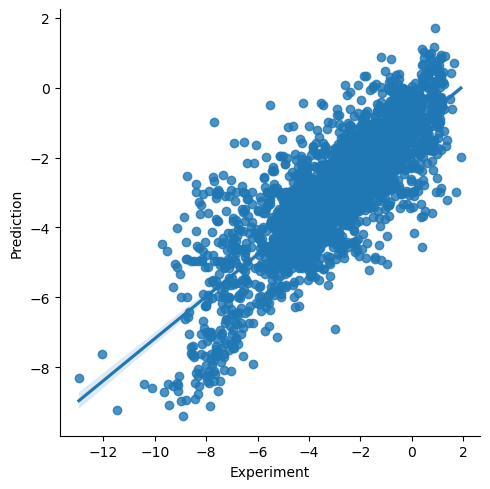

In [13]:
sns.lmplot(x="Experiment",y="Prediction",data=pred_df);

Calcuate stats

In [14]:
r2 = r2_score(pred,test.LogS)
rmse = mean_squared_error(pred,test.LogS,squared=False)
r2, rmse

(0.36963135979247663, 1.41962810190742)

Now we're going to create a classification model.  We'll use a 30 $\mu$M cutoff to divide soluble molecules from insoluble. As a sanity check, make a distribution plot to make sure we did this correctly. 

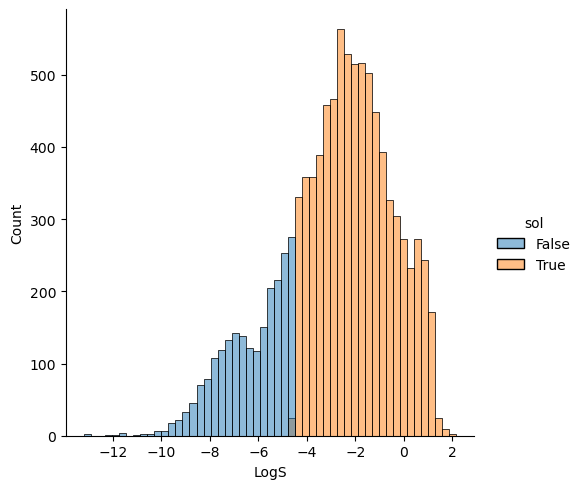

In [15]:
cutoff = np.log10(30*1e-6)
df['sol'] = df.LogS > cutoff
sns.displot(x="LogS",hue="sol",data=df);

Create a classifier.

In [16]:
hgbc = HistGradientBoostingClassifier()

Split training a test sets.

In [17]:
train, test = train_test_split(df)

Train the classification model.

In [18]:
hgbc.fit(np.stack(train.numpy_fp),train.sol)

HistGradientBoostingClassifier()

Predict on the test sest. 

In [19]:
cls_pred = hgbc.predict(np.stack(test.numpy_fp))

Get the classification stats.

In [20]:
f"AUC = {roc_auc_score(test.sol,cls_pred):.2f} MCC = {matthews_corrcoef(test.sol,cls_pred):.2f}"

'AUC = 0.78 MCC = 0.61'

### 2. Generate analogs of our target molecule with CrEM

As a test we'll use [Palbociclib](https://en.wikipedia.org/wiki/Palbociclib)

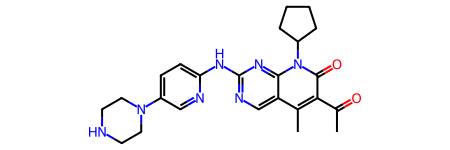

In [21]:
palbo_smi = "CC(=O)C1=C(C)c2cnc(Nc3ccc(cn3)N4CCNCC4)nc2N(C5CCCC5)C1=O"
palbo_mol = Chem.MolFromSmiles(palbo_smi)
palbo_mol

Generate a numpy fingerprint for Palbociclib.

In [22]:
palbo_numpy_fp = uru.mol2numpy_fp(palbo_mol)

Predict solbuility for the Palbociclib fingerprint. 

In [23]:
hgbc.predict([palbo_numpy_fp])

array([False])

Generate a list of analogs for Palbociclib. 

In [24]:
!ls

data                                  replacements02_sc2.5.db
explaining_with_counterfactuals.ipynb


In [25]:
analog_smi_list = list(mutate_mol(palbo_mol, db_name='replacements02_sc2.5.db', max_size=10))

Put the analogs in a dataframe. 

In [26]:
analog_df = pd.DataFrame({"SMILES" : analog_smi_list})
len(analog_df)

272

### 3. Calculate similarity and solubility for the analogs

In [27]:
# add an RDKit molecule to the dataframe
analog_df['mol'] = analog_df.SMILES.progress_apply(Chem.MolFromSmiles)
# add a Morgan fingerprint for similarity calculations
analog_df['morgan_fp'] = analog_df.mol.progress_apply(uru.mol2morgan_fp)
# add a numpy fingerprint for ML predictions
analog_df['numpy_fp'] = analog_df.mol.progress_apply(uru.mol2numpy_fp)

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

Generate a Morgan fingerprint for Palbociclib

In [28]:
palbo_morgan_fp = uru.mol2morgan_fp(palbo_mol)

Calculate the similarity of the analogs to Palbociclib

In [29]:
analog_df['sim'] = DataStructs.BulkTanimotoSimilarity(palbo_morgan_fp,analog_df.morgan_fp.values)

Calculate solubility for the analogs of Palbociclib

In [30]:
analog_df['pred_sol'] = hgbc.predict(np.stack(analog_df.numpy_fp))

Get a summary of the predicited solubilities

In [31]:
analog_df.pred_sol.value_counts()

False    197
True      75
Name: pred_sol, dtype: int64

Plot predicited solubility as a function of similarity to Palbociclib.

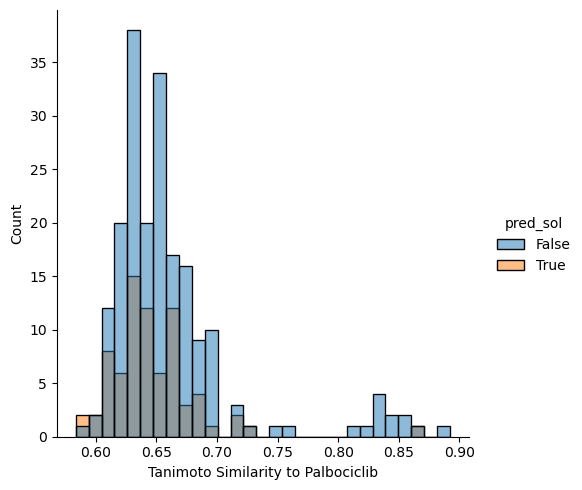

In [32]:
ax = sns.displot(x="sim",data=analog_df, hue="pred_sol")
ax.set(xlabel="Tanimoto Similarity to Palbociclib");

Take a look at the predicted solubilities of the analogs and their similarity to Palbociclib. 

In [33]:
mols2grid.display(analog_df,
                 subset=["img","pred_sol","sim"],selection=False,
                 style={"pred_sol": lambda x: "color: green" if x else "color: red"},
                 transform={"sim": lambda x: f"{x:.2f}"})

MolGridWidget()

### 4. View counterfactual examples 

Sort the data by similarity to Palbociclib and select only the molecules predicted to be soluble.

In [34]:
counterfactual_df = analog_df.sort_values("sim",ascending=False).query("pred_sol == True").copy()

In [35]:
counterfactual_df["mol_idx"] = range(0,len(counterfactual_df))

In [36]:
mols2grid.display(counterfactual_df,subset=["img","sim","mol_idx"],mol_col="mol",transform={"sim": lambda x: f"{x:.2f}"},
                  selection=False)

MolGridWidget()

A function to display aligned pairs of molecules and highlight their differences. 

In [37]:
def plot_analog_diffs(m1, m2):
    mcs = rdFMCS.FindMCS([m1,m2],completeRingsOnly=False)
    mcs_query = Chem.MolFromSmarts(mcs.smartsString)
    AllChem.Compute2DCoords(mcs_query)
    for m in [m1,m2]: 
        AllChem.GenerateDepictionMatching2DStructure(m,mcs_query)
    m1_match = [x for x in range(0,m1.GetNumAtoms()) if x not in m1.GetSubstructMatch(mcs_query)]
    m2_match = [x for x in range(0,m2.GetNumAtoms()) if x not in m2.GetSubstructMatch(mcs_query)]
    return MolsToGridImage([m1,m2],highlightAtomLists=[m1_match,m2_match],subImgSize=(400, 400))

Set **selection_index** to the integer value below a structure in the table above to compare it with Palbociclib. 

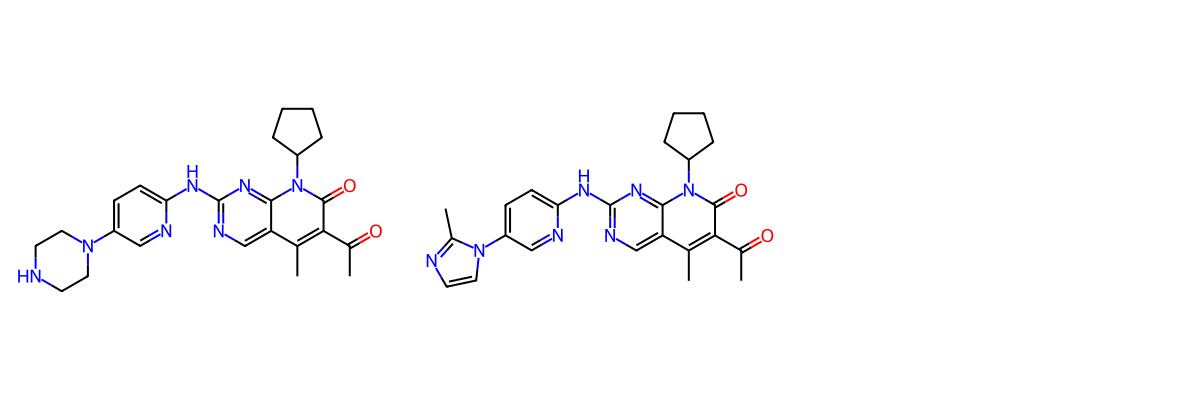

In [38]:
selection_index = 1
plot_analog_diffs(palbo_mol, counterfactual_df.mol.values[selection_index])